In [42]:
import numpy as np
import pandas as pd
import random 
import time 
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import nbinom
from collections import deque
from scipy.optimize import least_squares
from tqdm import trange

In [29]:
# ------------------------------------------------------------------
# 1.  Data — replace with your own cumulative case matrix
# ------------------------------------------------------------------
cases = pd.read_csv("/Users/boyapeng/Desktop/Dissertation/Aim1/Data/case_count.csv",header=0)

# Extract Date and Gaines, remove if NA
case_df = (
    cases[["Update Date", "Gaines"]]          # keep only the needed cols
         .loc[1:]
         .assign(
             Gaines=lambda d: pd.to_numeric(d["Gaines"], errors="coerce"),
             Date=lambda d: pd.to_datetime(d["Update Date"])
         )
         .dropna(subset=["Gaines"])           # drop rows where Gaines is NaN
         .set_index("Date")                   # set date as index
         .drop(columns="Update Date")         # drop redundant col
         .sort_index()
)

# Prepare the proportion dataframe
prop_path = "/Users/boyapeng/Desktop/Dissertation/Aim1/Data/case_age_prop_ext.csv"
prop_df   = pd.read_csv(prop_path)
prop_df.rename(columns={prop_df.columns[0]: "Date"}, inplace=True)
prop_df[["Prop_0-4", "Prop_5-17", "Prop_18+"]] = prop_df[
    ["Prop_0-4", "Prop_5-17", "Prop_18+"]
].astype(float)
prop_df["Date"] = pd.to_datetime(prop_df["Date"])
prop_df = prop_df.set_index("Date").sort_index()

# Ensure both dataframes cover the same dates
case_aligned = case_df.reindex(prop_df.index)

# Keep only dates where we have a real case count
valid_idx      = case_aligned["Gaines"].notna()   # Boolean mask
case_filtered  = case_aligned.loc[valid_idx]      # drop NaNs
prop_filtered  = prop_df.loc[valid_idx]           # keep matching rows

# Multiply to get age-stratified counts
case_counts = (
    case_filtered["Gaines"].to_numpy().reshape(-1, 1) *
    prop_filtered[["Prop_0-4", "Prop_5-17", "Prop_18+"]].to_numpy()
).round().astype(int).tolist() 
case_counts = np.array(case_counts)

# Time
date = case_df.index.to_series()
ts_cases = ((date - date.iloc[0]).dt.days + date.iloc[0].day).tolist() #calendar-day indices
ts_cases = np.array(ts_cases)

n_age = 3
n_obs = len(case_counts)

/var/folders/vy/m4l1bmcs7xd4nmd991yq7qkr0000gn/T/ipykernel_60794/2236793400.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Date=lambda d: pd.to_datetime(d["Update Date"])


In [3]:
N_raw = np.array([2341, 6500, 13682], dtype=int)   # population
V_raw = np.array([1988, 4536, 11616], dtype=int)   # one-dose total
E_raw = np.zeros(n_age, dtype=int)                 # exposed
I_raw = np.array([0, 1, 0], dtype=int)             # infectious

# Initialize y0 vector (length 10*n_age)
y0 = np.zeros(10 * n_age)

# Vaccination rate (daily proportion vaccinated)
v = 0.003

# Vaccine efficacy (leakey)
epsA = 1  
epsL = 0.97

# Exposed to infectious rate
sigma = float(np.random.gamma(shape=10, scale=1/80))

# Infectious to recovered rate
gamma1 = 1/3

# Underreporting rate
rep = 0.9

# Contact matrix (flattened row-major order) ##time-varying
C = np.array([
    1.4101, 2.5282, 4.9100,
    0.9290,11.0091, 6.0771,
    0.4884, 1.6387, 8.8461
])
C_flat = C.ravel(order="C")  

x_r = [v, epsA, epsL, sigma, gamma1, rep] + C.flatten(order='C').tolist()
x_i = [n_age] + N_raw.tolist() + V_raw.tolist() + E_raw.tolist() + I_raw.tolist()

In [30]:
# ------------------------------------------------------------------
# 2.  Deterministic SEIRHD ODE
# ------------------------------------------------------------------
def seirhd_ode(t, y, theta, x_r, x_i):
    """
    SEIRHD ODE with clearer indexing.

    Parameters
    ----------
    t : float
        Current time (unused but required by ODE solver signature).
    y : ndarray
        State vector ordered by age block:
            [S1, VS1, VR1, S2, V2, E, I, R, C] × n_age.
    theta : ndarray
        Age-specific β followed by scalar contact modifier:
            [β_0, …, β_{n_age−1}, con, (optional tail...)].
    x_r : ndarray
        Fixed real parameters:
            [v, epsA, epsL, sigma, gamma1, rep, *Cflat*].
    x_i : ndarray
        Fixed integer parameters:
            [n_age, N_pop_0, …, N_pop_{n_age−1}].
    """
    n_age = int(x_i[0])

    beta = np.asarray(theta[:n_age], dtype=float)  # β per age
    con  = float(theta[n_age])                    # contact modifier

    v, epsA, epsL, sigma, gamma1, rep = x_r[:6]
    Cmat = np.reshape(x_r[6:], (n_age, n_age))    # contact matrix

    N_pop = np.asarray(x_i[1:1 + n_age], dtype=float)

    dydt = np.zeros_like(y)

    for i in range(n_age):
        idx = i * 9
        S1, VS1, VR1, S2, V2, E, I, R, C = y[idx : idx + 9]

        # Force of infection λ_i
        lam_i = 0.0
        for j in range(n_age):
            jdx = j * 9
            Ij  = max(y[jdx + 6], 0.0)
            Nj  = N_pop[j] - y[jdx + 3] - y[jdx + 4]  # exclude protected
            lam_i += Cmat[i, j] * Ij / Nj

        lam   = beta[i] * lam_i
        v_eff = v if i == 0 else 0.0  # adjust if vaccination varies by age

        # Compartment flows
        dydt[idx + 0] = -lam * S1 - v_eff * S1
        dydt[idx + 1] = (1 - epsA) * v_eff * S1 - lam * VS1
        dydt[idx + 2] = epsA * v_eff * S1 - lam * (1 - epsL) * VR1
        dydt[idx + 3] = -v_eff * S2
        dydt[idx + 4] = v_eff * S2
        dydt[idx + 5] = lam * (S1 + VS1 + (1 - epsL) * VR1) - sigma * E
        dydt[idx + 6] = sigma * E - gamma1 * I
        dydt[idx + 7] = gamma1 * I
        dydt[idx + 8] = sigma * E  # cumulative cases

    return dydt

def build_y0(con):

    y0 = np.zeros(9 * n_age, dtype=float)

    S_base = N_raw - V_raw - E_raw - I_raw       # susceptibles (all flavours)

    for j in range(n_age):
        idx = 9 * j
        y0[idx + 0] = S_base[j]         * con
        y0[idx + 1] = (1 - epsA) * V_raw[j] * con
        y0[idx + 2] =      epsA  * V_raw[j] * con

        y0[idx + 3] = S_base[j]         * (1 - con)
        y0[idx + 4] = V_raw[j]          * (1 - con)

        y0[idx + 5] = E_raw[j]                       # E
        y0[idx + 6] = I_raw[j]                       # I
        y0[idx + 7] = 0.0                            # R
        y0[idx + 8] = I_raw[j]                       # cumulative cases
    return y0


In [71]:
# ------------------------------------------------------------------
# 0.  Problem setup: bounds, data, ODE helpers
# ------------------------------------------------------------------
# Parameter order: β0, β1, β2, con, t0
LOW  = np.array([0.10, 0.10, 0.10, 0.01,  1])   # lower bounds
HIGH = np.array([5.00, 5.00, 5.00, 1.00, 28])   # upper bounds

def predict_cum(params):
    β0, β1, β2, con, t0 = params
    theta = np.array([β0, β1, β2, con], dtype=float)
    y0    = build_y0(con)
    t_eval  = np.array(ts_cases) - t0
    sol   = solve_ivp(
        seirhd_ode, (0, t_eval[-1]), y0,
        args=(theta, x_r, x_i), t_eval=t_eval, vectorized=False
    )
    return sol.y[8::9, :].T        # (n_obs, n_age)
    
def fitness(individual):
    pred = predict_cum(individual)           # your output slice
    resid = pred - case_counts              # same shape
    mse   = (resid**2).mean()               # divide by n_obs * n_age
    return mse   

In [130]:
"""
Enhanced Tabu-Search optimizer for SEIRHD cumulative-case fitting.
"""

import numpy as np
from collections import deque
from concurrent.futures import ThreadPoolExecutor

# ------------------------------------------------------------------
# 1.  Tabu Search
# ------------------------------------------------------------------
def reflect(x, lo, hi):
    span = hi - lo
    return lo + np.abs((x - lo) % (2 * span) - span)

def tabu_search(
    n_iter=1500,
    tabu_size=100,
    n_neigh=150,
    step_scale=0.15,
    seed=None,
    elite_size=10,
):
    rng        = np.random.default_rng(seed)
    current    = LOW + rng.random(LOW.shape) * (HIGH - LOW) #random start between bounds
    best       = current.copy()
    best_f     = fitness(best)
    best_run   = best_f
    tabu_q     = deque([tuple(np.round(current, 3))], maxlen=tabu_size)
    elite_q    = deque(maxlen=elite_size)
    acc_hist   = []
    prev_cur_f = best_f

    # record of best MSE
    mse_traj   = [best_f]            

    for it in range(n_iter):
        neigh_list = []

        # ---------- generate neighbours ----------------------
        for _ in range(n_neigh):
            step = np.zeros_like(current)
            # coordinate-kick on one random gene
            coord      = rng.integers(0, current.size)
            step[coord] = rng.normal(0, step_scale)

            # Lévy jump every 20 iters
            if it and it % 20 == 0:
                step += rng.standard_cauchy(current.size) * 0.02

            cand = current + step * (HIGH - LOW) #next step
            cand[4] = np.round(cand[4])                 # integer t0
            # if over bounds, bounce back
            for d in range(cand.size):
                if cand[d] < LOW[d] or cand[d] > HIGH[d]:
                    cand[d] = reflect(cand[d], LOW[d], HIGH[d])

            key = tuple(np.round(cand, 3))
            if key in tabu_q:  #check within the accepted points
                continue
            neigh_list.append(cand) #if no, continue to evaluate

        # parallel evaluation
        with ThreadPoolExecutor() as pool:
            neigh_scores = list(pool.map(fitness, neigh_list))

        if not neigh_list:      # all neighbours tabu
            continue

        idx        = int(np.argmin(neigh_scores)) #pick the one with best MSE
        cand       = neigh_list[idx]
        cand_f     = neigh_scores[idx]
        tabu_q.append(tuple(np.round(cand, 3)))

        # --------- move acceptance & adaptive σ -------------
        #Accept as the new current only if it improved on the previous current
        accepted = cand_f < prev_cur_f 
        if accepted:
            current, prev_cur_f = cand, cand_f

        acc_hist.append(accepted)
        if (it + 1) % 50 == 0:                      # 20 % acceptance target
            acc_rate   = np.mean(acc_hist[-50:])
            if   acc_rate > 0.25: step_scale *= 1.2
            elif acc_rate < 0.15: step_scale *= 0.8
            step_scale = np.clip(step_scale, 0.02, 0.5)

        # --------- elite diversification --------------------
        if cand_f < best_f:
            best, best_f = cand.copy(), cand_f
            elite_q.append(cand.copy())
            mse_traj.append(best_f)
            #print(f"Iter {it:4d}   best MSE = {best_f:.4f}")

        #Every 30 iterations jump to a random elite:
        if elite_q and it and it % 30 == 0:
            current      = elite_q[rng.integers(len(elite_q))].copy()
            prev_cur_f   = fitness(current)          # refresh loss

    return best, best_f, mse_traj


In [131]:
# ------------------------------------------------------------------
# 2.  Run search ----------------------------------------------------
if __name__ == "__main__":
    best_pars, best_mse, mse_traj = tabu_search()
    best_rmse = best_mse ** 0.5

    print("\nBest parameters:", best_pars)
    print("Best MSE:",  best_mse)
    print("Best RMSE:", best_rmse)
    


Best parameters: [ 4.99983269  0.16730292  0.18908565  0.07397382 25.        ]
Best MSE: 32.55965723278358
Best RMSE: 5.706107012034


In [120]:
pred_cum = predict_cum(best_pars) 
obs_cum = np.asarray(case_counts, dtype=float)   

β0, β1, β2, con, t0 = best_pars
t_eval  = np.array(ts_cases) - t0

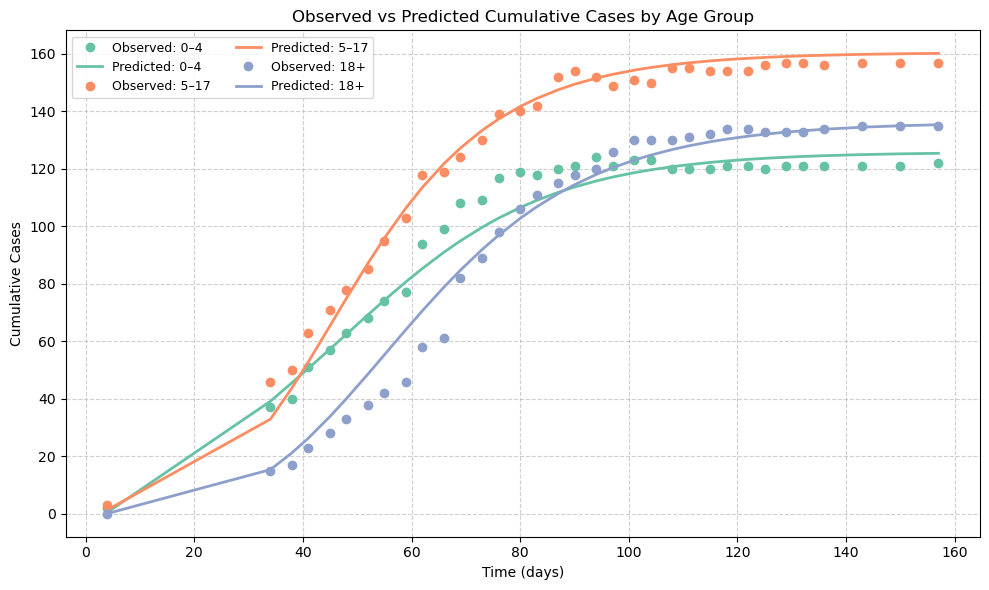

In [121]:
# -------------------------------------------------------------------
# 4.  Plot: predicted vs observed
# -------------------------------------------------------------------
age_labels = ['0–4', '5–17', '18+']
colors     = plt.get_cmap('Set2')

plt.figure(figsize=(10, 6))

for k in range(pred_cum.shape[1]):
    # Observed
    plt.plot(t_eval, obs_cum[:, k], 'o',
             markersize=6, color=colors(k),
             label=f'Observed: {age_labels[k]}')
    # Predicted
    plt.plot(t_eval, pred_cum[:, k], '-',
             linewidth=2, color=colors(k),
             label=f'Predicted: {age_labels[k]}')

plt.xlabel('Time (days)')
plt.ylabel('Cumulative Cases')
plt.title('Observed vs Predicted Cumulative Cases by Age Group')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

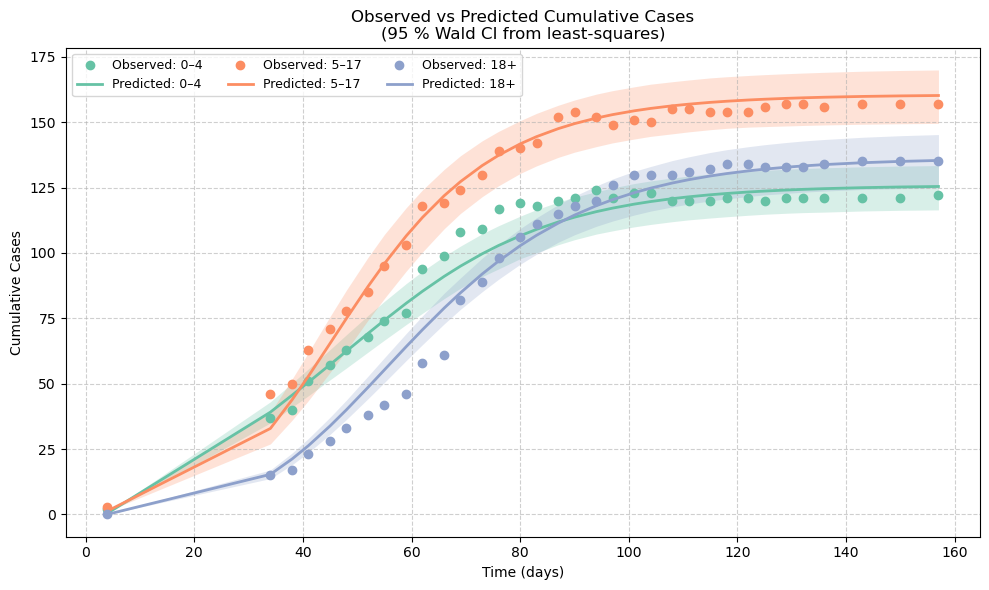


Wald 95 % parameter CIs:
 β0:   4.9992  [  4.2584,   5.7400]
 β1:   0.1670  [  0.1503,   0.1836]
 β2:   0.1889  [  0.1757,   0.2021]
con:   0.0741  [  0.0686,   0.0797]
 t0:  25.0000  [ 24.9955,  25.0045]


In [122]:
# Try a non-linear least-squares method
from scipy.optimize import least_squares
from scipy.stats import t, multivariate_normal as mvn

# ---------------------------------------------------------------
# Non-linear Least–squares refinement (nlinfit analogue)
# Re-optimises in case GA is off by a hair.
# Returns J, the sensitivity of each residual to each parameter
# ---------------------------------------------------------------

#Taylor’s power law (around beta/2)
eps          = 1e-6                       # avoid divide-by-zero
#weight  = 1.0 / np.sqrt(obs_cum + eps)   # (n_obs, n_age)
weight  = 1.0 / (obs_cum/rep + eps)**1.1

#def resid(theta_vec):
#    return (predict_cum(theta_vec) - obs_cum).ravel()   # flatten to 1-D
def resid_wls(theta_vec):
    pred = predict_cum(theta_vec)         # (n_obs, n_age)
    wr   = (pred - obs_cum) * weight # weight each residual
    return wr.ravel()                     # (n_obs*n_age,)

#res = least_squares(resid, best_par, method="trf", jac="2-point",
#                    bounds=([0,0,0,0.01,1], [6,6,6,0.99,28]))  # example bounds
res = least_squares(
        resid_wls,
        x0      = best_pars,
        bounds  = ([0,0,0,0.01, 1], [6,6,6,0.99, ts_cases[0]-1e-3]),
        method  = "trf",
        jac     = "2-point"
)

theta_hat = best_pars
J         = res.jac                 # (N_obs*n_age) × p
N, p      = J.shape
sse       = np.sum(res.fun**2)
sigma2    = sse / (N - p)         #residual variance

# Wald (nlparci-style) covariance
cov_theta = sigma2 * np.linalg.inv(J.T @ J)

# ---------------------------------------------------------------
# 3.  Parameter draw cloud (1 000 draws from N(θ̂, Σ̂))
# ---------------------------------------------------------------
n_draws   = 1000
rng       = np.random.default_rng(42)
theta_draws = rng.multivariate_normal(theta_hat, cov_theta, size=n_draws)
theta_draws[:,4] = np.clip(theta_draws[:,4], 1, 28) # Clip / reflect** t0 into range

pred_stack = np.stack([predict_cum(th) for th in theta_draws])  # (n_draws,n_obs,n_age)

pred_mean  = pred_cum   #pred_stack.mean(axis=0)
pred_low   = np.percentile(pred_stack,  2.5, axis=0)
pred_high  = np.percentile(pred_stack, 97.5, axis=0)

# ---------------------------------------------------------------
# 4.  Plot
# ---------------------------------------------------------------
age_labels = ['0–4', '5–17', '18+']
colors     = plt.get_cmap('Set2')

plt.figure(figsize=(10, 6))
for k in range(pred_mean.shape[1]):
    plt.fill_between(t_eval, pred_low[:, k], pred_high[:, k],
                     color=colors(k), alpha=0.25, linewidth=0)
    plt.plot(t_eval, obs_cum[:, k], 'o', markersize=6,
             color=colors(k), label=f'Observed: {age_labels[k]}')
    plt.plot(t_eval, pred_mean[:, k], '-', linewidth=2,
             color=colors(k), label=f'Predicted: {age_labels[k]}')

plt.xlabel('Time (days)')
plt.ylabel('Cumulative Cases')
plt.title('Observed vs Predicted Cumulative Cases\n(95 % Wald CI from least-squares)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 5.  Optional: print parameter CIs
# ---------------------------------------------------------------
alpha = 0.05
tcrit = t.ppf(1 - alpha/2, df=N - p)
ci_lo = theta_hat - tcrit * np.sqrt(np.diag(cov_theta))
ci_hi = theta_hat + tcrit * np.sqrt(np.diag(cov_theta))
param_names = ["β0", "β1", "β2", "con", "t0"]

print("\nWald 95 % parameter CIs:")
for name, lo, est, hi in zip(param_names, ci_lo, theta_hat, ci_hi):
    print(f"{name:>3s}: {est:8.4f}  [{lo:8.4f}, {hi:8.4f}]")


In [123]:
# ---------------------------------------------------------------
# Coverage of the 95 % CI ribbon
# ---------------------------------------------------------------
# pred_low, pred_high : (n_obs, n_age)
# obs_cum             : (n_obs, n_age)

inside_mask = (obs_cum >= pred_low) & (obs_cum <= pred_high)
n_inside    = int(inside_mask.sum())                  # True → 1
n_total     = obs_cum.size                            # n_obs * n_age
coverage    = n_inside / n_total * 100.0

print(f"Observed points inside 95 % CI : {n_inside} / {n_total} "
      f"({coverage:.1f} %)")

Observed points inside 95 % CI : 78 / 102 (76.5 %)


## Diagnosis

In [136]:
import time, numpy as np

n_runs  = 5
records = []

for i in range(n_runs):
    t0 = time.time()
    best_pars, best_mse, _ = tabu_search()          # ← your optimiser
    dt = time.time() - t0
    dt_m = dt/60

    pred = predict_cum(best_pars)                # (n_obs , n_age)
    rmse = np.sqrt(((pred - case_counts)**2).mean())
    mae  = np.abs(pred - case_counts).mean()

    records.append((rmse, mae, dt_m))
    print(f"run {i+1:2d}: RMSE={rmse:.3f}  MAE={mae:.3f}  time={dt_m:.1f}min")

# ---------- aggregate ---------------------------------------------
vals   = np.array(records)                       # shape (20, 3)
means  = vals.mean(axis=0)
stderr = vals.std(axis=0, ddof=1) / np.sqrt(n_runs)
ci95   = 1.96 * stderr

print("\nSummary  (mean ± 95% CI)")
for label, m, c in zip(["RMSE", "MAE", "Runtime (s)"], means, ci95):
    print(f"{label:12s}: {m:.3f} ± {c:.3f}")


run  1: RMSE=5.691  MAE=4.297  time=52.5min
run  2: RMSE=5.692  MAE=4.316  time=59.9min
run  3: RMSE=5.712  MAE=4.264  time=51.3min
run  4: RMSE=5.712  MAE=4.177  time=174.9min
run  5: RMSE=9.328  MAE=8.053  time=49.6min

Summary  (mean ± 95% CI)
RMSE        : 6.427 ± 1.422
MAE         : 5.021 ± 1.486
Runtime (s) : 77.633 ± 47.764


ΔMSE over last 10 iters = 0.2613


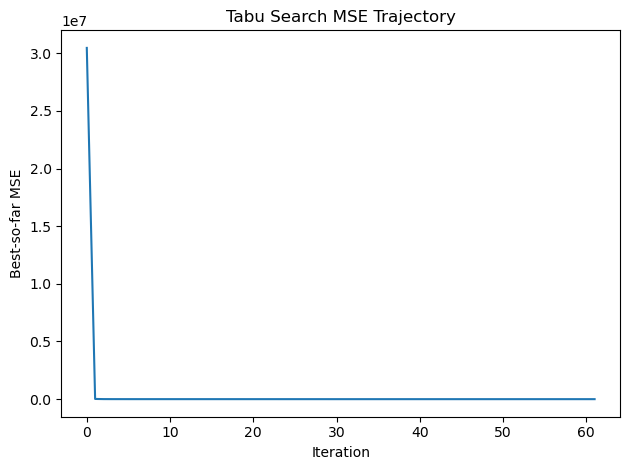

In [137]:
#MSE
# 2) Compute ΔMSE over the last 10 iterations
last10     = mse_traj[-5:]
delta_mse  = max(last10) - min(last10)
print(f"ΔMSE over last 10 iters = {delta_mse:.4f}")

# 3) Plot the trajectory

plt.figure()
plt.plot(mse_traj)
plt.xlabel("Iteration")
plt.ylabel("Best‐so‐far MSE")
plt.title("Tabu Search MSE Trajectory")
plt.tight_layout()
plt.show()

In [133]:
mse_traj

[30457820.27597039,
 18803.54574252482,
 5431.767444335055,
 3181.704292720406,
 2445.59002176978,
 1967.4305816942694,
 1825.9783934540064,
 1809.1434679972817,
 1806.7009483319719,
 1804.746115262555,
 1687.1681038352845,
 1632.874180056073,
 1577.9087486531769,
 1509.955949680363,
 1497.1802975691191,
 1493.4025511846755,
 1427.1538562644137,
 1323.959879606042,
 1290.230819458648,
 1191.4265733977256,
 1177.0140815885718,
 1136.476785644185,
 1033.654061324101,
 961.7473716408316,
 900.1453243672921,
 768.3479484935054,
 688.4495430771958,
 585.8780099456079,
 411.09063483191,
 106.54164690302085,
 95.33486335613844,
 93.65786053609506,
 93.60265014458038,
 86.64805047758439,
 70.88461269420668,
 65.93358954457469,
 65.76109745476822,
 58.21454389346611,
 57.438445261825166,
 56.02287330448461,
 43.44420809515857,
 43.21728617714887,
 42.81516055511207,
 39.98706902833667,
 38.05522894960762,
 37.888582842985656,
 37.6972173824029,
 37.32340485753161,
 37.27991223471365,
 37.232021

In [138]:
#Save MSE in CSV
def append_mse_traj(csv_file, new_traj, col_name):
    """
    Append a new MSE trajectory as a column in a CSV.
    If the file exists, it merges with existing columns,
    filling with NaN where lengths differ.
    """
    try:
        # Load existing
        df = pd.read_csv(csv_file)
    except FileNotFoundError:
        # Start a new DataFrame if CSV doesn’t exist
        df = pd.DataFrame()

    # Add / overwrite column
    df[col_name] = pd.Series(new_traj)

    # Save back
    df.to_csv(csv_file, index=False)
    print(f"Column '{col_name}' written to {csv_file}")

append_mse_traj("mse_traj.csv", mse_traj, "TS")

Column 'TS' written to mse_traj.csv
